# 2. Import libraries and read data

In [1]:
import joblib
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis


# 4. Modeling

## 4.1 Model preparation

### 4.1.1 Train-Test Split

In [2]:
from joblib import Parallel, delayed
from joblib import parallel_backend

In [3]:
df = pd.read_csv("data_resampled_5.csv")

### 4.1.3 Cross Vallidation

In [4]:
majority_class = df[df['Outcome'] == 0]
minority_class = df[df['Outcome'] == 1]

# Define the number of samples to select
n_samples = 50

# Perform random sampling
sampled_majority = majority_class.sample(n_samples, random_state=123)
sampled_minority = minority_class.sample(n_samples, random_state=123)

# Combine sampled data
sampled_df = pd.concat([sampled_majority, sampled_minority])
sampled_df

#test
y_test = sampled_df['Outcome']
x_test = sampled_df.drop(columns='Outcome')

# train
# Separate remaining data for training
remaining_df = df.drop(sampled_df.index)
y_train = remaining_df['Outcome']
x_train= remaining_df.drop(columns='Outcome')

scaler = StandardScaler()
scaler.fit(x_train)

x_train_ = scaler.transform(x_train)
x_test_ = scaler.transform(x_test)

In [5]:
#from sklearn.model_selection import RepeatedKFold
rs=123
cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=345)

## Basic Structure of an Optuna Optimization Script

The overall process works differently from the brute-force approach of GridSearchCV. Because of this, let's cover off the different components of the process:

1. Defining the objective function
2. Creating a Study Object
3. Running the Optimization Process

The objective function is at the core of how Optuna optimizes the hyperparameter selections. While a brute-force grid search also seeks to minimize an objective function, it doesn't actually take into account what combination of hyperparameters is doing well or not.

## 4.2 KNN (K-Nearest Neighbors Algorithm)

In [6]:
# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [7]:
# Creating and running our optimization
study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
study_knn.optimize(objective_knn, n_trials=50)

[I 2024-08-26 18:48:08,609] A new study created in memory with name: KNN
[I 2024-08-26 18:48:21,037] Trial 0 finished with value: 0.6384119517046599 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'p': 20, 'algorithm': 'ball_tree', 'leaf_size': 7}. Best is trial 0 with value: 0.6384119517046599.
[I 2024-08-26 18:48:22,292] Trial 1 finished with value: 0.49020769284320637 and parameters: {'n_neighbors': 73, 'weights': 'distance', 'metric': 'euclidean', 'p': 16, 'algorithm': 'auto', 'leaf_size': 64}. Best is trial 0 with value: 0.6384119517046599.
[I 2024-08-26 18:48:24,096] Trial 2 finished with value: 0.5048417441091897 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'manhattan', 'p': 21, 'algorithm': 'ball_tree', 'leaf_size': 87}. Best is trial 0 with value: 0.6384119517046599.
[I 2024-08-26 18:48:24,802] Trial 3 finished with value: 0.49020769284320637 and parameters: {'n_neighbors': 63, 'weights': 'distance', 'metric': 'euclidean

[I 2024-08-26 18:50:36,569] Trial 32 finished with value: 0.5726289919004519 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'euclidean', 'p': 5, 'algorithm': 'auto', 'leaf_size': 19}. Best is trial 11 with value: 0.7931453703326623.
[I 2024-08-26 18:50:37,742] Trial 33 finished with value: 0.5337839363638542 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'metric': 'euclidean', 'p': 12, 'algorithm': 'auto', 'leaf_size': 28}. Best is trial 11 with value: 0.7931453703326623.
[I 2024-08-26 18:50:38,775] Trial 34 finished with value: 0.5726289919004519 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'euclidean', 'p': 1, 'algorithm': 'auto', 'leaf_size': 15}. Best is trial 11 with value: 0.7931453703326623.
[I 2024-08-26 18:50:39,532] Trial 35 finished with value: 0.772810240787186 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean', 'p': 6, 'algorithm': 'auto', 'leaf_size': 33}. Best is trial 11 with value: 0.79314

In [8]:
# Evaluating our Optuna Trial
print("Best trial:", study_knn.best_trial.number)
print("Best accuracy:", study_knn.best_trial.value)
print("Best hyperparameters:", study_knn.best_params)

Best trial: 11
Best accuracy: 0.7931453703326623
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 35}


              precision    recall  f1-score   support

           0       0.71      1.00      0.83        50
           1       1.00      0.60      0.75        50

    accuracy                           0.80       100
   macro avg       0.86      0.80      0.79       100
weighted avg       0.86      0.80      0.79       100



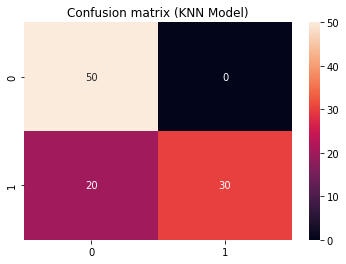

In [9]:
best_param_knn = study_knn.best_params
KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
y_pred_knn = KNN.predict(x_test_)

def display_results(y_test, y_pred, cm_title):
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
    print(classification_report(y_test,y_pred))
    
display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

Accuracy: 0.8000
Precision: 1.0000
Recall: 0.6000
F1 Score: 0.7500

Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        50
           1       1.00      0.60      0.75        50

    accuracy                           0.80       100
   macro avg       0.86      0.80      0.79       100
weighted avg       0.86      0.80      0.79       100



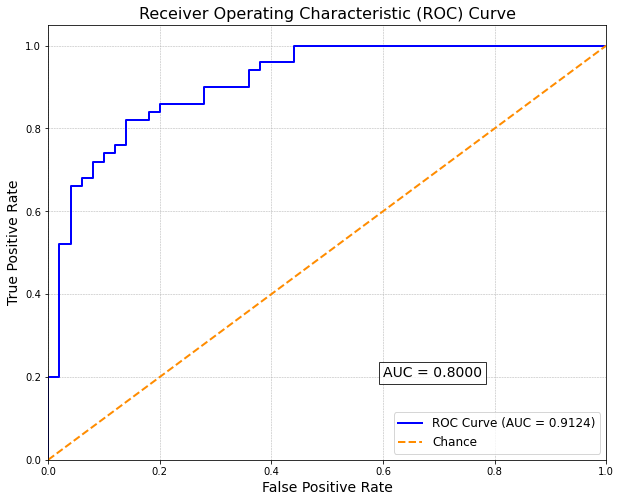

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, classification_report

# Get the best parameters from the Optuna study and train the KNN model
best_knn = KNeighborsClassifier(**study_knn.best_params)
best_knn.fit(x_train_, y_train)

# Predict on the test set
y_pred = best_knn.predict(x_test_)
y_proba = best_knn.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot the ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_knn:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()


## 4.3 Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def objective_lr(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }

    # Define hyperparameters
    param_logr = {
        'C': trial.suggest_float("C", 0.001, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
        'max_iter': trial.suggest_int("max_iter", 50, 1000),
        'class_weight': class_weight  # Apply custom class weights
    }

    # Create and train the model
    lr = LogisticRegression(**param_logr, random_state=42)
    
    # Evaluate the model using cross-validation with the f1_macro score to handle imbalance
    score = cross_val_score(lr, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score



In [12]:
# Creating and running our optimization

study_lr = optuna.create_study(direction='maximize',study_name = "logr")
study_lr.optimize(objective_lr, n_trials=50)

[I 2024-08-26 18:50:55,387] A new study created in memory with name: logr
[I 2024-08-26 18:50:55,923] Trial 0 finished with value: 0.5057261808819268 and parameters: {'C': 0.0016530493456973741, 'solver': 'liblinear', 'max_iter': 572}. Best is trial 0 with value: 0.5057261808819268.
[I 2024-08-26 18:50:56,531] Trial 1 finished with value: 0.5116451960427318 and parameters: {'C': 0.0032833473977460286, 'solver': 'liblinear', 'max_iter': 554}. Best is trial 1 with value: 0.5116451960427318.
[I 2024-08-26 18:51:09,447] Trial 2 finished with value: 0.44749584378441887 and parameters: {'C': 0.3154649049803502, 'solver': 'saga', 'max_iter': 647}. Best is trial 1 with value: 0.5116451960427318.
[I 2024-08-26 18:51:12,035] Trial 3 finished with value: 0.5727742702902173 and parameters: {'C': 7.491103636523969, 'solver': 'lbfgs', 'max_iter': 462}. Best is trial 3 with value: 0.5727742702902173.
[I 2024-08-26 18:51:13,016] Trial 4 finished with value: 0.5729972275105981 and parameters: {'C': 1.2

[I 2024-08-26 18:53:14,572] Trial 40 finished with value: 0.42297348514513244 and parameters: {'C': 2.617895884031948, 'solver': 'saga', 'max_iter': 406}. Best is trial 24 with value: 0.5733044061850435.
[I 2024-08-26 18:53:15,548] Trial 41 finished with value: 0.573253360086144 and parameters: {'C': 1.9470841999704922, 'solver': 'liblinear', 'max_iter': 536}. Best is trial 24 with value: 0.5733044061850435.
[I 2024-08-26 18:53:16,525] Trial 42 finished with value: 0.5731269437519371 and parameters: {'C': 1.3037786366615396, 'solver': 'liblinear', 'max_iter': 500}. Best is trial 24 with value: 0.5733044061850435.
[I 2024-08-26 18:53:17,583] Trial 43 finished with value: 0.573222536444167 and parameters: {'C': 6.693987031831415, 'solver': 'liblinear', 'max_iter': 599}. Best is trial 24 with value: 0.5733044061850435.
[I 2024-08-26 18:53:18,556] Trial 44 finished with value: 0.5730704512481385 and parameters: {'C': 2.069330936278836, 'solver': 'liblinear', 'max_iter': 490}. Best is trial

In [13]:
# Evaluating our Optuna Trial
print("Best trial:", study_lr.best_trial.number)
print("Best accuracy:", study_lr.best_trial.value)
print("Best hyperparameters:", study_lr.best_params)

Best trial: 24
Best accuracy: 0.5733044061850435
Best hyperparameters: {'C': 4.171481664070341, 'solver': 'liblinear', 'max_iter': 640}


              precision    recall  f1-score   support

           0       0.51      1.00      0.67        50
           1       1.00      0.02      0.04        50

    accuracy                           0.51       100
   macro avg       0.75      0.51      0.36       100
weighted avg       0.75      0.51      0.36       100



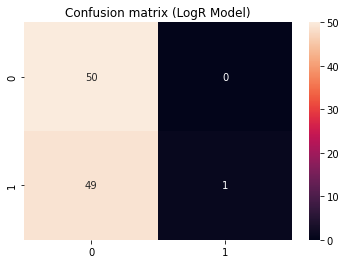

In [14]:
best_param_logr = study_lr.best_params
LR = LogisticRegression(**best_param_logr).fit(x_train_,y_train)
y_pred_lr = LR.predict(x_test_)
    
display_results(y_test, y_pred_lr, cm_title = "Confusion matrix (LogR Model)")

Accuracy: 0.5100
Precision: 1.0000
Recall: 0.0200
F1 Score: 0.0392

Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        50
           1       1.00      0.02      0.04        50

    accuracy                           0.51       100
   macro avg       0.75      0.51      0.36       100
weighted avg       0.75      0.51      0.36       100



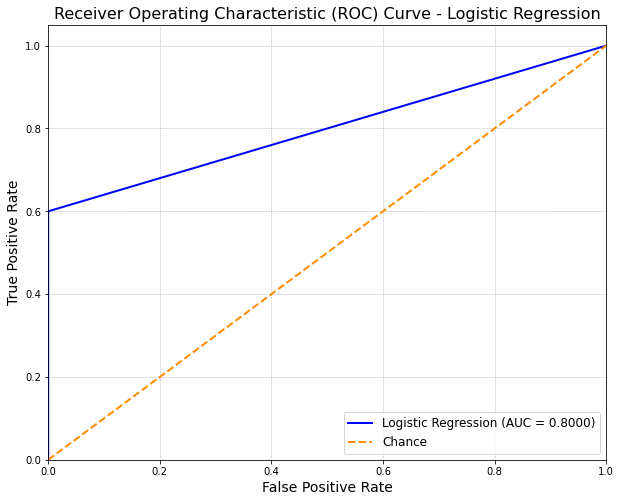

In [42]:
# Predict on the test set
y_pred_lr = LR.predict(x_test_)
y_proba_lr = LR.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Plot the ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_knn:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)


# Show the plot
plt.show()

## 4.4 Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective_dect(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_dect = {
        'max_depth' : trial.suggest_int("max_depth", 2, 64),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0.001, 10.0, log=True),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 30),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 30),
        'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'class_weight': class_weight
    }

    # Create and train the model
    dect = DecisionTreeClassifier(**param_dect, random_state=123)
    dect.fit(x_train, y_train)

    # Evaluate the model
    score = cross_val_score(dect, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [17]:
# Creating and running our optimization

study_dect = optuna.create_study(direction='maximize',study_name = "Dect")
study_dect.optimize(objective_dect, n_trials=50)

[I 2024-08-26 18:53:35,973] A new study created in memory with name: Dect
[I 2024-08-26 18:53:36,341] Trial 0 finished with value: 0.5989141390296258 and parameters: {'max_depth': 6, 'ccp_alpha': 0.19352972851265532, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5989141390296258.
[I 2024-08-26 18:53:36,566] Trial 1 finished with value: 0.26837064534735694 and parameters: {'max_depth': 2, 'ccp_alpha': 2.9257842743933486, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5989141390296258.
[I 2024-08-26 18:53:36,964] Trial 2 finished with value: 0.26837064534735694 and parameters: {'max_depth': 14, 'ccp_alpha': 0.48669472980768336, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.5989141390296258.
[I 2024-08-26 18:53:37,353] Trial 3 finished with value: 0.598914

[I 2024-08-26 18:53:47,103] Trial 28 finished with value: 0.6550797307449275 and parameters: {'max_depth': 51, 'ccp_alpha': 0.0027233540467369735, 'max_features': 'auto', 'min_samples_split': 28, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 28 with value: 0.6550797307449275.
[I 2024-08-26 18:53:47,509] Trial 29 finished with value: 0.6580124135616912 and parameters: {'max_depth': 39, 'ccp_alpha': 0.0023591753793711927, 'max_features': 'auto', 'min_samples_split': 28, 'min_samples_leaf': 12, 'criterion': 'entropy'}. Best is trial 29 with value: 0.6580124135616912.
[I 2024-08-26 18:53:47,915] Trial 30 finished with value: 0.26837064534735694 and parameters: {'max_depth': 39, 'ccp_alpha': 0.38429276687623504, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 12, 'criterion': 'entropy'}. Best is trial 29 with value: 0.6580124135616912.
[I 2024-08-26 18:53:48,322] Trial 31 finished with value: 0.6603131260547738 and parameters: {'max_depth': 50, 'ccp_alp

In [18]:
# Evaluating our Optuna Trial
print("Best trial:", study_dect.best_trial.number)
print("Best accuracy:", study_dect.best_trial.value)
print("Best hyperparameters:", study_dect.best_params)

Best trial: 44
Best accuracy: 0.7178974954222533
Best hyperparameters: {'max_depth': 27, 'ccp_alpha': 0.0010504388083691406, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 5, 'criterion': 'gini'}


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



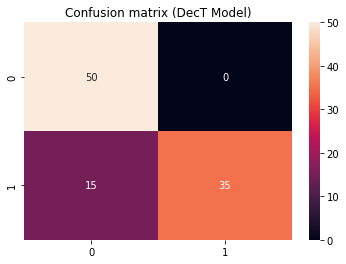

In [19]:
best_param_dect = study_dect.best_params
DecT = DecisionTreeClassifier(**best_param_dect,random_state=42).fit(x_train,y_train)
y_pred_dect = DecT.predict(x_test)
    

display_results(y_test, y_pred_dect, cm_title = "Confusion matrix (DecT Model)")

Accuracy: 0.8600
Precision: 1.0000
Recall: 0.7200
F1 Score: 0.8372

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        50
           1       1.00      0.72      0.84        50

    accuracy                           0.86       100
   macro avg       0.89      0.86      0.86       100
weighted avg       0.89      0.86      0.86       100



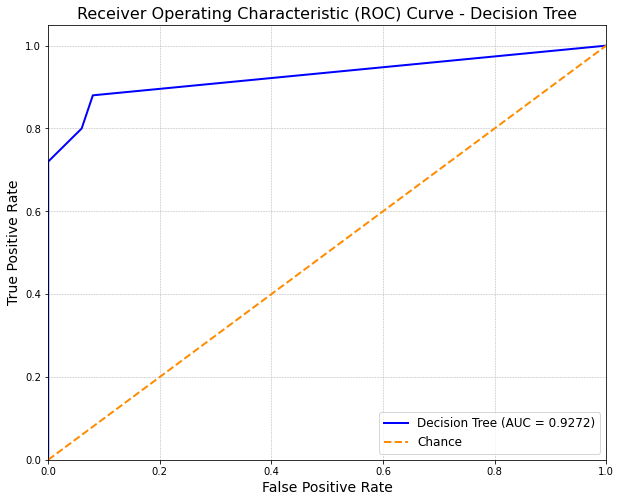

In [20]:
# Train the best Decision Tree model
best_param_dect = study_dect.best_params
best_dect = DecisionTreeClassifier(**best_param_dect, random_state=123)
best_dect.fit(x_train_, y_train)

# Predict on the test set
y_pred_dect = best_dect.predict(x_test_)
y_proba_dect = best_dect.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_dect = accuracy_score(y_test, y_pred_dect)
precision_dect = precision_score(y_test, y_pred_dect)
recall_dect = recall_score(y_test, y_pred_dect)
f1_dect = f1_score(y_test, y_pred_dect)

print(f"Accuracy: {accuracy_dect:.4f}")
print(f"Precision: {precision_dect:.4f}")
print(f"Recall: {recall_dect:.4f}")
print(f"F1 Score: {f1_dect:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dect))

# Plot the ROC curve
fpr_dect, tpr_dect, _ = roc_curve(y_test, y_proba_dect)
roc_auc_dect = auc(fpr_dect, tpr_dect)

plt.figure(figsize=(10, 8))
plt.plot(fpr_dect, tpr_dect, color='blue', lw=2, label=f'Decision Tree (AUC = {roc_auc_dect:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)


# Show the plot
plt.show()

## 4.5 SVM (Support Vector Machine)

In [21]:
# Creating an Objective Function

def objective_svm(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
                'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0),
                'class_weight': class_weight
                }

    # Create and train the model
    svm = SVC(**param_svm,random_state=rs)
    svm.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(svm, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [22]:
# Creating and running our optimization

study_svm = optuna.create_study(direction='maximize',study_name ="SVM")
study_svm.optimize(objective_svm, n_trials=20)

[I 2024-08-26 18:53:55,501] A new study created in memory with name: SVM
[I 2024-08-26 18:54:09,571] Trial 0 finished with value: 0.7829912057234079 and parameters: {'C': 5.5878643216925905, 'gamma': 0.10856234337207496}. Best is trial 0 with value: 0.7829912057234079.
[I 2024-08-26 18:54:49,136] Trial 1 finished with value: 0.5900580588374423 and parameters: {'C': 38.27267548289795, 'gamma': 0.00020313045722596094}. Best is trial 0 with value: 0.7829912057234079.
[I 2024-08-26 18:55:27,717] Trial 2 finished with value: 0.5995402328628188 and parameters: {'C': 9.177760411376985, 'gamma': 0.0014078086019109713}. Best is trial 0 with value: 0.7829912057234079.
[I 2024-08-26 18:56:45,152] Trial 3 finished with value: 0.26837064534735694 and parameters: {'C': 0.010166577348279223, 'gamma': 4.766771595893958e-05}. Best is trial 0 with value: 0.7829912057234079.
[I 2024-08-26 18:57:00,729] Trial 4 finished with value: 0.7754182011024326 and parameters: {'C': 0.6418457911525567, 'gamma': 0.45

In [23]:
# Evaluating our Optuna Trial
print("Best trial:", study_svm.best_trial.number)
print("Best accuracy:", study_svm.best_trial.value)
print("Best hyperparameters:", study_svm.best_params)

Best trial: 5
Best accuracy: 0.8531262902425912
Best hyperparameters: {'C': 469.1107016473626, 'gamma': 0.14386623268242704}


              precision    recall  f1-score   support

           0       0.76      1.00      0.86        50
           1       1.00      0.68      0.81        50

    accuracy                           0.84       100
   macro avg       0.88      0.84      0.84       100
weighted avg       0.88      0.84      0.84       100



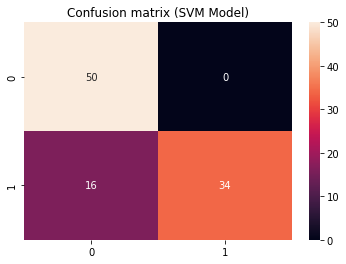

In [24]:
best_param_svm = study_svm.best_params
SVM = SVC(**best_param_svm,random_state=rs).fit(x_train_,y_train)
y_pred_svm = SVM.predict(x_test_)

display_results(y_test, y_pred_svm, cm_title = "Confusion matrix (SVM Model)")

Accuracy: 0.8400
Precision: 1.0000
Recall: 0.6800
F1 Score: 0.8095

Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        50
           1       1.00      0.68      0.81        50

    accuracy                           0.84       100
   macro avg       0.88      0.84      0.84       100
weighted avg       0.88      0.84      0.84       100



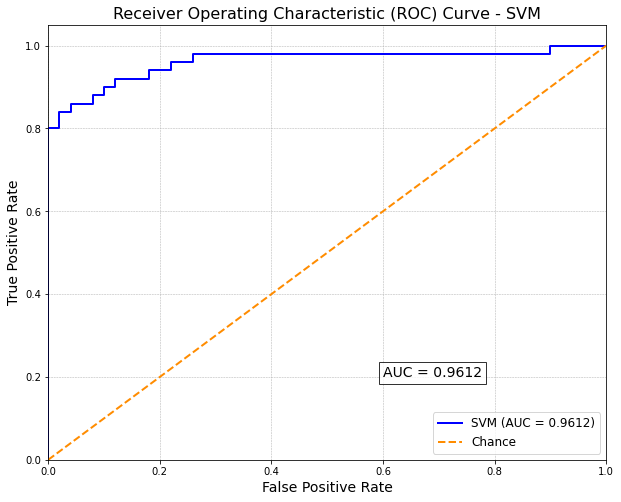

In [25]:
# Train the best SVM model
best_param_svm = study_svm.best_params
best_svm = SVC(**best_param_svm, random_state=123, probability=True)
best_svm.fit(x_train_, y_train)

# Predict on the test set
y_pred_svm = best_svm.predict(x_test_)
y_proba_svm = best_svm.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Plot the ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_svm:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()

## Xgboost

In [26]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

def objective_xgb(trial: optuna.Trial):
    # Assume the data is already split into x_train_ and y_train_
    n_minority = y_train.sum()  # Number of minority class instances (assume minority class is '1')
    n_majority = len(y_train) - n_minority  # Number of majority class instances (assume majority class is '0')
    
    # Calculate scale_pos_weight
    scale_pos_weight = n_majority / n_minority
    
    # Define hyperparameters
    param_xgb = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': 0.1,  # Fixed at 0.1 as per your instructions
        'n_estimators': 200,  # Fixed at 200
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'scale_pos_weight': scale_pos_weight  # Calculated to handle class imbalance
    }

    # Create and evaluate the XGBoost model
    xgb_model = xgb.XGBClassifier(**param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
    score = cross_val_score(xgb_model, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

# Example usage:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=100)


In [27]:
pos_weight = y_train.sum() / (len(y_train) - y_train.sum())
pos_weight

0.03990374974934831

In [28]:
# Creating and running our optimization
study_xgb = optuna.create_study(direction='maximize', study_name="XGBoost")

with parallel_backend('threading'):
    study_xgb.optimize(objective_xgb, n_trials=20, n_jobs=-1)

[I 2024-08-26 19:06:11,364] A new study created in memory with name: XGBoost
[I 2024-08-26 19:07:46,692] Trial 1 finished with value: 0.84966621058378 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.5635911013276522, 'colsample_bytree': 0.7179893676784628, 'reg_alpha': 5.368104493310543, 'reg_lambda': 0.0005285206592869669}. Best is trial 1 with value: 0.84966621058378.
[I 2024-08-26 19:08:23,630] Trial 0 finished with value: 0.8941237658049797 and parameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.5403186366830512, 'colsample_bytree': 0.9192931792864127, 'reg_alpha': 3.922131867044767, 'reg_lambda': 2.55044386128693e-05}. Best is trial 0 with value: 0.8941237658049797.
[I 2024-08-26 19:08:28,132] Trial 4 finished with value: 0.9135613521901875 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8939775053288532, 'colsample_bytree': 0.8390914788808845, 'reg_alpha': 0.007892572700223904, 'reg_lambda': 0.0024088136736219413}. Best

In [29]:
# Evaluating our Optuna Trial
print("Best trial:", study_xgb.best_trial.number)
print("Best accuracy:", study_xgb.best_trial.value)
print("Best hyperparameters:", study_xgb.best_params)


Best trial: 17
Best accuracy: 0.9167194048313883
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.9805888243503965, 'colsample_bytree': 0.7012310367812291, 'reg_alpha': 0.000812980479782261, 'reg_lambda': 4.412913247573848}


In [30]:
# Train the best XGBoost model
best_param_xgb = study_xgb.best_params
best_xgb = xgb.XGBClassifier(**best_param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
best_xgb.fit(x_train_, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7012310367812291, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=8,
              max_leaves=0, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0.000812980479782261, reg_lambda=4.412913247573848, ...)

Accuracy: 0.8800
Precision: 1.0000
Recall: 0.7600
F1 Score: 0.8636

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        50
           1       1.00      0.76      0.86        50

    accuracy                           0.88       100
   macro avg       0.90      0.88      0.88       100
weighted avg       0.90      0.88      0.88       100



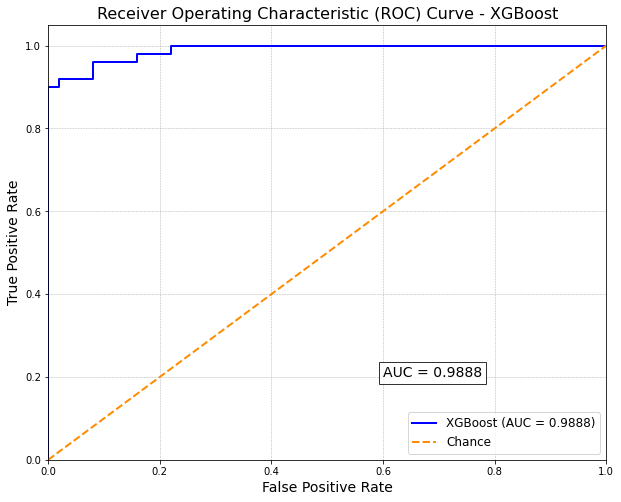

In [31]:
# Predict on the test set
y_pred_xgb = best_xgb.predict(x_test_)
y_proba_xgb = best_xgb.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Plot the ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_xgb:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()

# 5. Models Comparison

The ROC-Curve plot provides us with a clear view to choose the best model, as it is evident that the decision tree model has the largest area under the curve. Therefore, based on the ROC , the decision tree model is selected as the best model.

In [40]:
# Create a dictionary to store the metrics for each model
metrics_summary = {
    "Model": ["KNN", "SVM", "LR", "DecT", "XGB"],
    "Accuracy": [accuracy_knn, accuracy_svm, accuracy_lr, accuracy_dect, accuracy_xgb],
    "Recall": [recall_knn, recall_svm, recall_lr, recall_dect, recall_xgb],
    "Precision": [precision_knn, precision_svm, precision_lr, precision_dect, precision_xgb],
    "F1-Score": [f1_knn, f1_svm, f1_lr, f1_dect, f1_xgb],
    "AUC": [roc_auc_lr, roc_auc_svm, roc_auc_knn, roc_auc_dect, roc_auc_xgb]
}

# Convert the dictionary into a DataFrame
metrics_df = pd.DataFrame(metrics_summary)

# Display the DataFrame
metrics_df


,Model,Accuracy,Recall,Precision,F1-Score,AUC
0,KNN,0.80,0.60,1.0,0.750000,0.9124
1,SVM,0.84,0.68,1.0,0.809524,0.9612
2,LR,0.51,0.02,1.0,0.039216,0.8000
3,DecT,0.86,0.72,1.0,0.837209,0.9272
4,XGB,0.88,0.76,1.0,0.863636,0.9888


In [35]:
metrics_df.to_excel('result/5.xlsx', index=False)

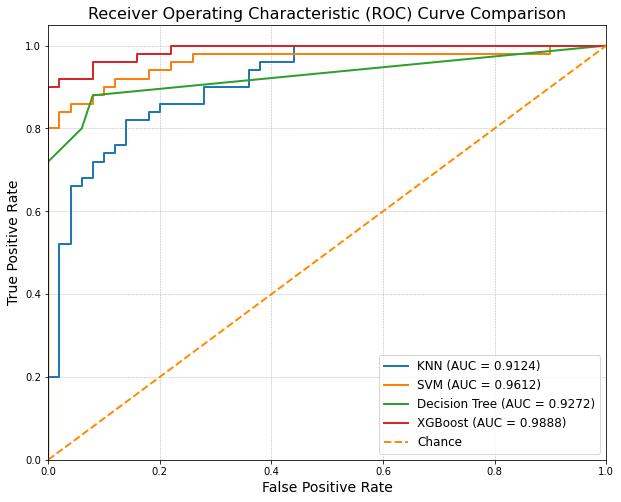

In [38]:
plt.figure(figsize=(10, 8))

# Plot ROC curve for KNN
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'KNN (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for SVM
plt.plot(fpr_svm, tpr_svm, lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')

# Plot ROC curve for Logistic Regression
#plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for Decision Tree
plt.plot(fpr_dect, tpr_dect, lw=2, label=f'Decision Tree (AUC = {roc_auc_dect:.4f})')

# Plot ROC curve for XGBoost
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Show the plot
plt.show()
